In [1]:
# Install required packages.
import os
import torch
import networkx as nx
import matplotlib.pyplot as plt
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color)
    plt.show()

2.0.1


In [2]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


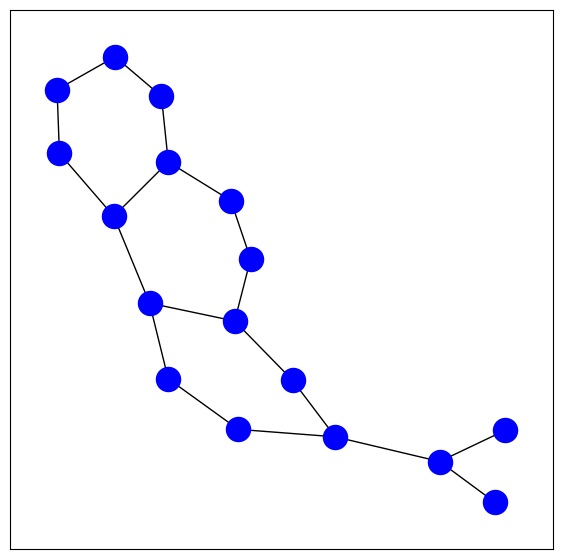

In [3]:
data = dataset[0]
print(data)
from torch_geometric.utils import to_networkx
col = ('blue' if data.y == 1 else 'red')

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=col)

In [4]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

In [6]:
from torch.nn import Linear
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [10]:
from sklearn.metrics import roc_auc_score

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.
    
    return loss.item()

def test(loader):
     model.eval()

     correct = 0
     probs = []
     datas = []
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)

         prob = F.softmax(out, dim=1).detach()
         probs += (prob[:,1].tolist())
         datas += (data.y.tolist())

         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.

     roc_auc = roc_auc_score(datas, probs)
     return correct / len(loader.dataset), roc_auc  # Derive ratio of correct predictions.

loss_train = []
train_acc_cum, test_acc_cum, roc_cum = [], [], []
for epoch in range(1, 201):
    loss_train.append(train())

    train_acc, _ = test(train_loader)
    train_acc_cum.append(train_acc)
    
    test_acc, roc = test(test_loader)
    test_acc_cum.append(test_acc)
    roc_cum.append(roc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, ROC_AUC: {roc:.4f}')

Epoch: 001, Train Acc: 0.6667, Test Acc: 0.7368, ROC_AUC: 0.8286
Epoch: 002, Train Acc: 0.7067, Test Acc: 0.7632, ROC_AUC: 0.8357
Epoch: 003, Train Acc: 0.7067, Test Acc: 0.7632, ROC_AUC: 0.8357
Epoch: 004, Train Acc: 0.7467, Test Acc: 0.7368, ROC_AUC: 0.8393
Epoch: 005, Train Acc: 0.7400, Test Acc: 0.7368, ROC_AUC: 0.8393
Epoch: 006, Train Acc: 0.7000, Test Acc: 0.6842, ROC_AUC: 0.8357
Epoch: 007, Train Acc: 0.7533, Test Acc: 0.7368, ROC_AUC: 0.8286
Epoch: 008, Train Acc: 0.7667, Test Acc: 0.7895, ROC_AUC: 0.8286
Epoch: 009, Train Acc: 0.7467, Test Acc: 0.7632, ROC_AUC: 0.8286
Epoch: 010, Train Acc: 0.7600, Test Acc: 0.8421, ROC_AUC: 0.8357
Epoch: 011, Train Acc: 0.7733, Test Acc: 0.7895, ROC_AUC: 0.8321
Epoch: 012, Train Acc: 0.7600, Test Acc: 0.7632, ROC_AUC: 0.8321
Epoch: 013, Train Acc: 0.7667, Test Acc: 0.7895, ROC_AUC: 0.8321
Epoch: 014, Train Acc: 0.7667, Test Acc: 0.8158, ROC_AUC: 0.8321
Epoch: 015, Train Acc: 0.7600, Test Acc: 0.7632, ROC_AUC: 0.8357
Epoch: 016, Train Acc: 0.

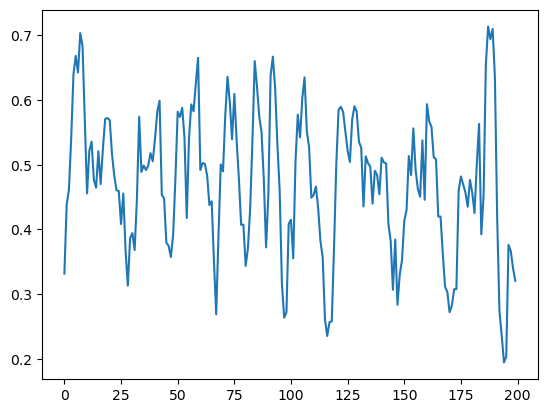

In [11]:
import matplotlib.pyplot as plt
import numpy as np
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

loss_train_av = movingaverage(loss_train, 5)
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(loss_train_av)  # Plot some data on the axes.

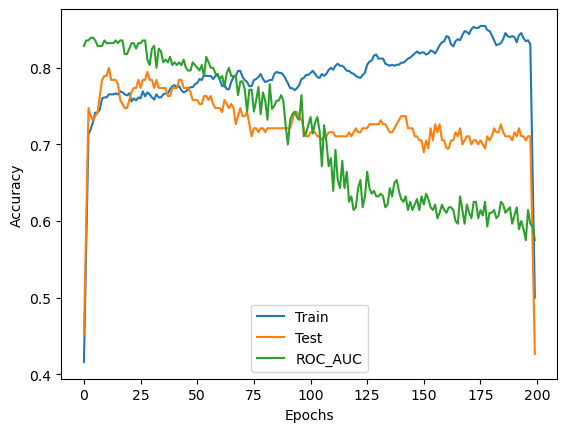

In [12]:
train_av = movingaverage(train_acc_cum, 5)
test_av = movingaverage(test_acc_cum, 5)

fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(train_av, label='Train')  # Plot some data on the axes.
ax.plot(test_av, label='Test')  # Plot some data on the axes.
ax.plot(roc_cum, label='ROC_AUC')  # Plot some data on the axes.
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()